In [1]:
%matplotlib inline
import cv2
from scipy.ndimage.filters import gaussian_filter
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import scipy
# from skimage import data

In [2]:
# gaussian_filter?
# np.arctan2?

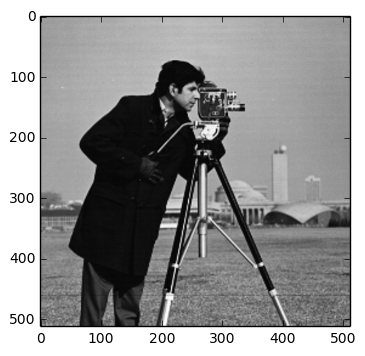

In [3]:
img = misc.imread('../../data/cameraman.jpg')
width, height = img.shape
# 图像处理过程一般转换为float64
img = img/1.0
plt.imshow(img, cmap='gray')

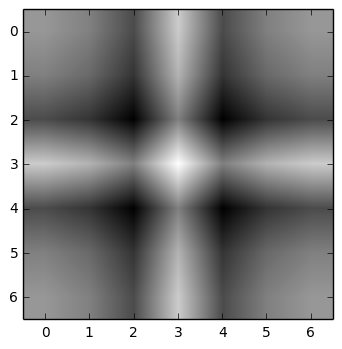

In [4]:
ksize = 7
kernel = np.zeros((ksize, ksize))
kernel[ksize//2, ksize//2]=1
kernel = gaussian_filter(kernel, sigma=7)
plt.imshow(kernel, cmap='gray')
img_gaussian = scipy.ndimage.convolve(img, kernel)

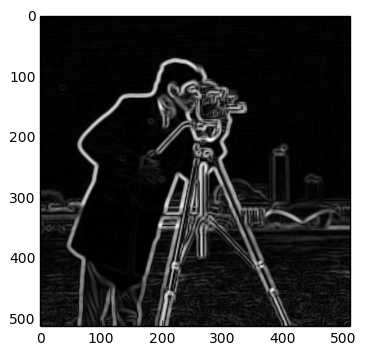

In [5]:
# 计算图像梯度（幅值和角度）
img_gaussian_sobelx = cv2.Sobel(img_gaussian, -1, dx=1, dy=0, ksize=3)
img_gaussian_sobely = cv2.Sobel(img_gaussian, -1, dx=0, dy=1, ksize=3)
# 计算梯度
gradient_image = np.sqrt(img_gaussian_sobelx**2 + img_gaussian_sobely**2)
# 计算角度
theta_radius = np.arctan2(img_gaussian_sobely, img_gaussian_sobelx)
theta = np.rad2deg(theta_radius)
plt.imshow(gradient_image ,cmap='gray')

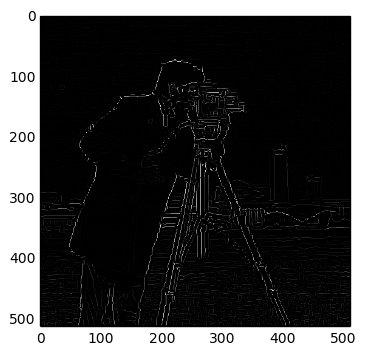

In [6]:
# 非极大值抑制

## 分类角度为0，45，90，135，即垂直，水平和两个对角线
theta[np.where(np.logical_or(np.logical_and(theta<22.5, theta>-22.5),np.logical_or(theta>157.5,theta<-157.5)))] = 0
theta[np.where(np.logical_or(np.logical_and(theta>22.5, theta<67.5), np.logical_and(theta<-112.5, theta>-157.5)))] = 45
theta[np.where(np.logical_or(np.logical_and(theta>67.5, theta<112.5),np.logical_and(theta<-67.5, theta>-112.5)))] = 90
theta[np.where(np.logical_or(np.logical_and(theta>112.5,theta<157.5),np.logical_and(theta<-22.5, theta>-67.5)))] = 135

edge_image = np.zeros_like(gradient_image)

## 0度非极大值抑制
theta_poses = np.argwhere(theta==0)
for theta_pos in theta_poses:
    theta_pos_row = theta_pos[0]
    theta_pos_col = theta_pos[1]
    if (theta_pos_row > 0) and (theta_pos_row < height-1) and (theta_pos_col > 0) and (theta_pos_col < width-1):
        if gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row][theta_pos_col-1] and gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row][theta_pos_col+1]:
            edge_image[theta_pos_row][theta_pos_col] = gradient_image[theta_pos_row][theta_pos_col]

## 45度非极大值抑制
theta_poses = np.argwhere(theta==45)
for theta_pos in theta_poses:
    theta_pos_row = theta_pos[0]
    theta_pos_col = theta_pos[1]
    if (theta_pos_row > 0) and (theta_pos_row < height-1) and (theta_pos_col > 0) and (theta_pos_col < width-1):
        if gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row-1][theta_pos_col+1] and gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row+1][theta_pos_col-1]:
            edge_image[theta_pos_row][theta_pos_col] = gradient_image[theta_pos_row][theta_pos_col]
            
## 90度非极大值抑制
theta_poses = np.argwhere(theta==90)
for theta_pos in theta_poses:
    theta_pos_row = theta_pos[0]
    theta_pos_col = theta_pos[1]
    if (theta_pos_row > 0) and (theta_pos_row < height-1) and (theta_pos_col > 0) and (theta_pos_col < width-1):
        if gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row-1][theta_pos_col] and gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row+1][theta_pos_col]:
            edge_image[theta_pos_row][theta_pos_col] = gradient_image[theta_pos_row][theta_pos_col]

## 135度非极大值抑制
theta_poses = np.argwhere(theta==135)
for theta_pos in theta_poses:
    theta_pos_row = theta_pos[0]
    theta_pos_col = theta_pos[1]
    if (theta_pos_row > 0) and (theta_pos_row < height-1) and (theta_pos_col > 0) and (theta_pos_col < width-1):
        if gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row-1][theta_pos_col-1] and gradient_image[theta_pos_row][theta_pos_col]>gradient_image[theta_pos_row+1][theta_pos_col+1]:
            edge_image[theta_pos_row][theta_pos_col] = gradient_image[theta_pos_row][theta_pos_col]

plt.imshow(edge_image, cmap='gray')


('high_edge_poses.shape:', (512, 512))


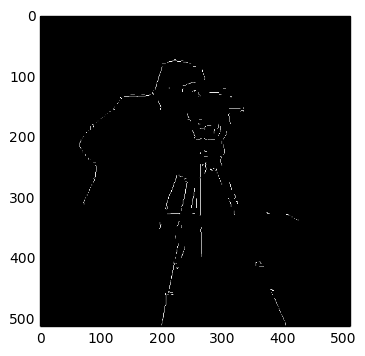

In [7]:
# 滞后阈值
canny_image = np.zeros_like(edge_image)

low_threshold = 0.1*255
high_threshld = 0.7*255

high_edge_poses = edge_image>high_threshld
canny_image[high_edge_poses] = 1
print('high_edge_poses.shape:', high_edge_poses.shape)
# print('high_edge_poses:', high_edge_poses)

weak_edge_poses = np.argwhere((edge_image<high_threshld) & (edge_image>low_threshold))

for weak_edge_pos in weak_edge_poses:
    weak_edge_pos_row = weak_edge_pos[0]
    weak_edge_pos_col = weak_edge_pos[1]
    # 检查像素八领域是否是强边缘响应
    if (weak_edge_pos_row > 0) and (weak_edge_pos_row < height-1) and (weak_edge_pos_col > 0) and (weak_edge_pos_col < width-1):
        north = (weak_edge_pos_row-1, weak_edge_pos_col)
        south = (weak_edge_pos_row+1, weak_edge_pos_col)
        west = (weak_edge_pos_row, weak_edge_pos_col-1)
        east = (weak_edge_pos_row, weak_edge_pos_col+1)
        north_west = (weak_edge_pos_row-1, weak_edge_pos_col-1)
        north_east = (weak_edge_pos_row-1, weak_edge_pos_col+1)
        south_west = (weak_edge_pos_row+1, weak_edge_pos_col-1)
        south_east = (weak_edge_pos_row+1, weak_edge_pos_col+1)
        
        if high_edge_poses[north[0], north[1]] or high_edge_poses[south[0], south[1]] or high_edge_poses[west[0], west[1]] or high_edge_poses[east[0], east[1]] or high_edge_poses[north_west[0], north_west[1]] or high_edge_poses[north_east[0], north_east[1]] or high_edge_poses[south_west[0], south_west[1]] or high_edge_poses[south_east[0], south_east[1]]:
            pass
            canny_image[weak_edge_pos_row, weak_edge_pos_col] = 1

plt.imshow(canny_image, cmap='gray')

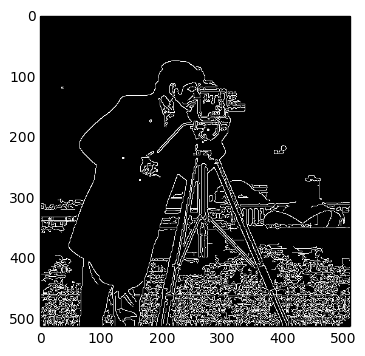

In [8]:
img = misc.imread('../../data/cameraman.jpg')
img_dst = cv2.Canny(img, threshold1=0.1*255, threshold2=0.7*255)
plt.imshow(img_dst, cmap='gray')